<a href="https://colab.research.google.com/github/MouseLand/suite2p/blob/main/jupyter/run_suite2p_colab_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install suite2p

In [2]:
import os, requests
from pathlib import Path
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import numpy as np

import suite2p

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [3]:
# Figure Style settings for notebook.
import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': False,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

# Running suite2p on example data

This notebook will guide you through the various stages and outputs of suite2p by running it on a real-life dataset. 

The next code cell downloads the data. You can also upload your own data to this folder on the left in the "Files" menu, or you can connect to your google drive (see instructions [here](https://colab.research.google.com/notebooks/io.ipynb)).


In [4]:
fname = "gt1.tif"
url = "https://www.suite2p.org/test_data/gt1.tif"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

from tifffile import imread
data = imread(fname)
print('imaging data of shape: ', data.shape)
n_time, Ly, Lx = data.shape

imaging data of shape:  (4500, 325, 556)


## Set pipeline parameters

You can find an explanation of each op parameters [here](https://suite2p.readthedocs.io/en/latest/settings.html).

In [5]:
ops = suite2p.default_ops()
ops['batch_size'] = 200 # we will decrease the batch_size in case low RAM on computer
print(ops)

{'suite2p_version': '0.10.1', 'look_one_level_down': False, 'fast_disk': [], 'delete_bin': False, 'mesoscan': False, 'bruker': False, 'bruker_bidirectional': False, 'h5py': [], 'h5py_key': 'data', 'save_path0': [], 'save_folder': [], 'subfolders': [], 'move_bin': False, 'nplanes': 1, 'nchannels': 1, 'functional_chan': 1, 'tau': 1.0, 'fs': 10.0, 'force_sktiff': False, 'frames_include': -1, 'multiplane_parallel': False, 'ignore_flyback': [], 'preclassify': 0.0, 'save_mat': False, 'save_NWB': False, 'combined': True, 'aspect': 1.0, 'do_bidiphase': False, 'bidiphase': 0, 'bidi_corrected': False, 'do_registration': 1, 'two_step_registration': False, 'keep_movie_raw': False, 'nimg_init': 300, 'batch_size': 200, 'maxregshift': 0.1, 'align_by_chan': 1, 'reg_tif': False, 'reg_tif_chan2': False, 'subpixel': 10, 'smooth_sigma_time': 0, 'smooth_sigma': 1.15, 'th_badframes': 1.0, 'norm_frames': True, 'force_refImg': False, 'pad_fft': False, 'nonrigid': True, 'block_size': [128, 128], 'snr_thresh': 

## Set Data Path
`ops` and `db` are functionally equivalent internally in suite2p, with the exception that parameters provided in `db` will overwrite parameters specified in `ops`.

**Tip**:  Since it's common to change datasets and keep the same parameters for each dataset, some might find it useful to specify data-related arguments in `db` and pipeline parameters in `ops`. 

In [6]:
db = {
    'data_path': [os.getcwd()],
    'save_path0': TemporaryDirectory().name,
}
print(db)

{'data_path': ['/content'], 'save_path0': '/tmp/tmpvwbljd9z'}


## Run Suite2p on Data

The `suite2p.run_s2p` function runs the pipeline and returns a list of output dictionaries containing the pipeline parameters used and extra data calculated along the way, one for each plane.

In [7]:
output_ops = suite2p.run_s2p(ops=ops, db=db)

{'data_path': ['/content'], 'save_path0': '/tmp/tmpvwbljd9z'}
tif
** Found 1 tifs - converting to binary **
800 frames of binary, time 1.06 sec.
1600 frames of binary, time 1.95 sec.
2400 frames of binary, time 3.08 sec.
3200 frames of binary, time 4.33 sec.
4000 frames of binary, time 5.56 sec.
time 6.43 sec. Wrote 4500 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
----------- REGISTRATION
registering 4500 frames
Reference frame, 53.89 sec.
Registered 800/4500 in 55.47s
Registered 1600/4500 in 111.14s
Registered 2400/4500 in 166.78s
Registered 3200/4500 in 220.93s
Registered 4000/4500 in 274.13s
added enhanced mean image
----------- Total 370.35 sec
Registration metrics, 32.05 sec.
NOTE: Applying builtin classifier at /usr/local/lib/python3.7/dist-packages/suite2p/classifiers/classifier.npy
----------- ROI DETECTION
Binning movie in chunk

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_ipix' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../usr/local/lib/python3.7/dist-packages/suite2p/extraction/extract.py", line 105:
@njit(parallel=True)
def matmul_traces(Fi, data, cell_ipix, cell_lam):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_lam' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-a

Extracted fluorescence from 4572 ROIs in 4500 frames, 66.93 sec.
----------- Total 74.91 sec.
----------- CLASSIFICATION
['npix_norm', 'skew', 'compact']
----------- Total 0.13 sec.
----------- SPIKE DECONVOLUTION
----------- Total 3.02 sec.
Plane 0 processed in 565.60 sec (can open in GUI).
total = 572.25 sec.
TOTAL RUNTIME 572.25 sec


### Outputs from the Suite2p Pipeline

#### Ops dictionaries

The ops dictionary contains all the keys that went into the analysis, plus new keys that contain additional metrics/outputs calculated during the pipeline run.

In [8]:
print(set(output_ops.keys()).difference(ops.keys()))

{'corrXY', 'rmax', 'date_proc', 'refImg', 'xoff', 'meanImgE', 'frames_per_file', 'Vcorr', 'yblock', 'Vsplit', 'reg_file', 'rmin', 'filelist', 'nframes', 'NRsm', 'spatscale_pix', 'meanImg', 'yoff', 'nblocks', 'regDX', 'data_path', 'max_proj', 'Lxc', 'frames_per_folder', 'Vmap', 'timing', 'badframes', 'yrange', 'xblock', 'yoff1', 'save_path', 'Ly', 'regPC', 'input_format', 'Lyc', 'xrange', 'Lx', 'xoff1', 'corrXY1', 'first_tiffs', 'Vmax', 'ops_path', 'ihop', 'tPC'}


#### Results Files

In [9]:
list(Path(output_ops['save_path']).iterdir())

[PosixPath('/tmp/tmpvwbljd9z/suite2p/plane0/stat.npy'),
 PosixPath('/tmp/tmpvwbljd9z/suite2p/plane0/ops.npy'),
 PosixPath('/tmp/tmpvwbljd9z/suite2p/plane0/Fneu.npy'),
 PosixPath('/tmp/tmpvwbljd9z/suite2p/plane0/spks.npy'),
 PosixPath('/tmp/tmpvwbljd9z/suite2p/plane0/iscell.npy'),
 PosixPath('/tmp/tmpvwbljd9z/suite2p/plane0/data.bin'),
 PosixPath('/tmp/tmpvwbljd9z/suite2p/plane0/F.npy')]

The output parameters can also be found in the "ops.npy" file.  This is especially useful when running the pipeline from the terminal or the graphical interface.  It contains the same data that is output from the python `run_s2p()` function.

In [10]:
output_ops_file = np.load(Path(output_ops['save_path']).joinpath('ops.npy'), allow_pickle=True).item()
output_ops_file.keys() == output_ops.keys()

True

The other files will be used for the visualizations below.

## Visualizations

### Registration

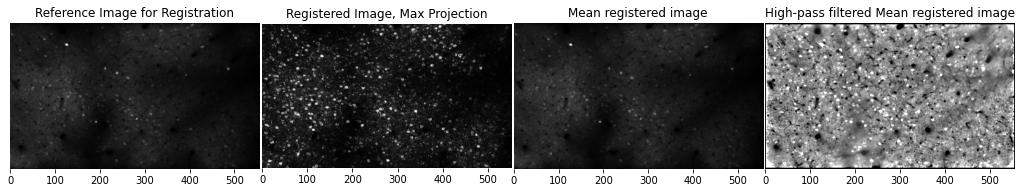

In [11]:
plt.subplot(1, 4, 1)
plt.imshow(output_ops['refImg'], cmap='gray', )
plt.title("Reference Image for Registration");

plt.subplot(1, 4, 2)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection");

plt.subplot(1, 4, 3)
plt.imshow(output_ops['meanImg'], cmap='gray')
plt.title("Mean registered image")

plt.subplot(1, 4, 4)
plt.imshow(output_ops['meanImgE'], cmap='gray')
plt.title("High-pass filtered Mean registered image");

### Detection


In [12]:
stats_file = Path(output_ops['save_path']).joinpath('stat.npy')
iscell = np.load(Path(output_ops['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(bool)
stats = np.load(stats_file, allow_pickle=True)
stats.shape, iscell.shape

((4572,), (4572,))

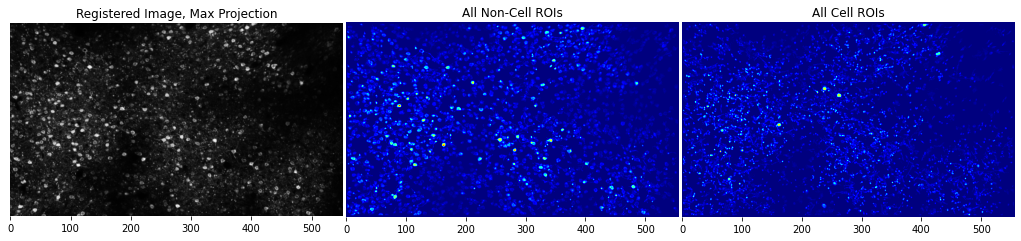

In [13]:
n_cells = len(stats)
im_cells = np.zeros((Ly, Lx), dtype=np.float32)
im_not_cells = np.zeros((Ly, Lx), dtype=np.float32)
for i, stat in enumerate(stats):
    ypix, xpix, lam = stat['ypix'], stat['xpix'], stat['lam']
    if iscell[i]:
        im_cells[ypix, xpix] = lam
    else:
        im_not_cells[ypix, xpix] = lam


plt.subplot(1, 3, 1)
plt.imshow(output_ops['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(1, 3, 2)
plt.imshow(im_cells, cmap='jet')
plt.title("All Non-Cell ROIs")

plt.subplot(1, 3, 3)
plt.imshow(im_not_cells, cmap='jet')
plt.title("All Cell ROIs");


### Traces


In [15]:
f_cells = np.load(Path(output_ops['save_path']).joinpath('F.npy'))
f_neuropils = np.load(Path(output_ops['save_path']).joinpath('Fneu.npy'))
spks = np.load(Path(output_ops['save_path']).joinpath('spks.npy'))
f_cells.shape, f_neuropils.shape, spks.shape

((4572, 4500), (4572, 4500), (4572, 4500))

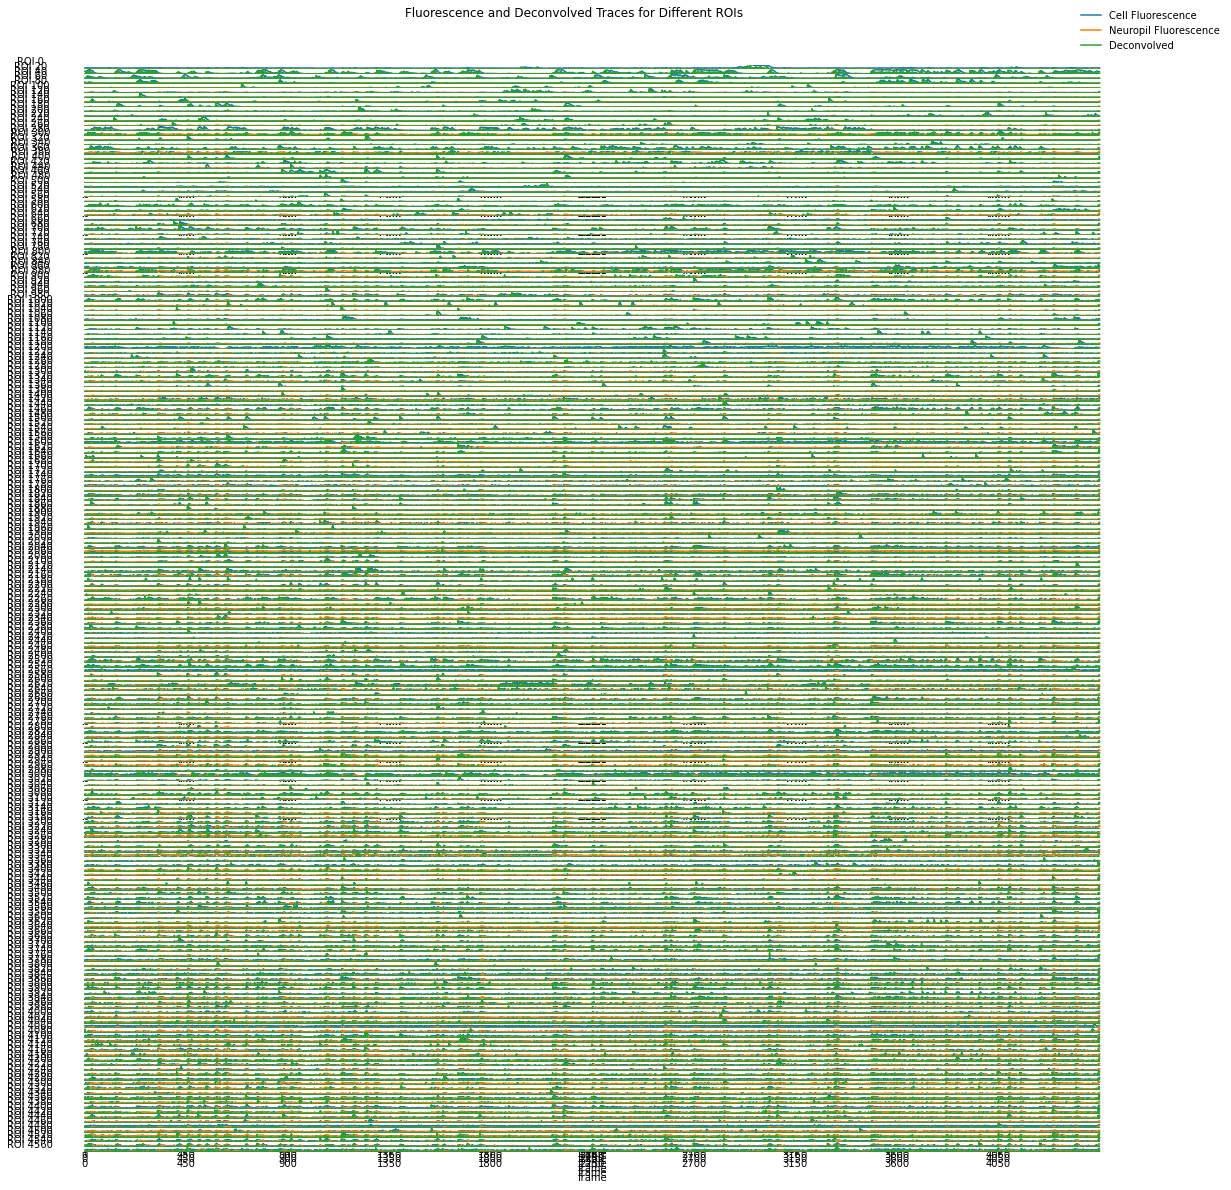

In [16]:
plt.figure(figsize=[20,20])
plt.suptitle("Fluorescence and Deconvolved Traces for Different ROIs", y=0.92);
rois = np.arange(len(f_cells))[::20]
for i, roi in enumerate(rois):
    plt.subplot(len(rois), 1, i+1, )
    f = f_cells[roi]
    f_neu = f_neuropils[roi]
    sp = spks[roi]
    # Adjust spks range to match range of fluroescence traces
    fmax = np.maximum(f.max(), f_neu.max())
    fmin = np.minimum(f.min(), f_neu.min())
    frange = fmax - fmin 
    sp /= sp.max()
    sp *= frange
    plt.plot(f, label="Cell Fluorescence")
    plt.plot(f_neu, label="Neuropil Fluorescence")
    plt.plot(sp + fmin, label="Deconvolved")
    plt.xticks(np.arange(0, f_cells.shape[1], f_cells.shape[1]/10))
    plt.ylabel(f"ROI {roi}", rotation=0)
    plt.xlabel("frame")
    if i == 0:
        plt.legend(bbox_to_anchor=(0.93, 2))